In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, glob
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import chirp, spectrogram, stft
from tftb.processing import WignerVilleDistribution
%matplotlib inline

In [2]:
obj_two_data = pd.read_excel('object2.xlsx', header = None)
obj_one_data = pd.read_excel('object1.xlsx', header = None)
obj_one_data.shape

(241, 16384)

In [3]:
obj_two_data.shape

(331, 16384)

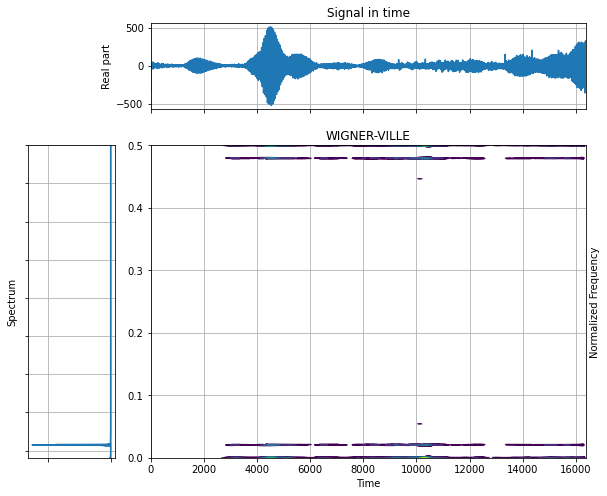

In [6]:
array_obj_two = np.array(obj_two_data)
array_obj_two = np.delete(array_obj_two, 1, 0)
array_obj_two = np.delete(array_obj_two, 1, 0)
array_obj_one = np.array(obj_one_data)
array_obj_one = np.delete(array_obj_one, 1, 0)

array_obj_one = np.delete(array_obj_one, 1, 0)

# mfccs_obj_two = array_obj_two[np.logical_not(np.isnan(array_obj_two))]
# mfccs_obj_one = array_obj_one[np.logical_not(np.isnan(array_obj_one))]
# spectral_rolloff = librosa.feature.spectral_rolloff(array_obj_two[3], sr=22050)
# spectral_rolloff[0][1]
tfr = WignerVilleDistribution(array_obj_two[4])
tfr.run()
tfr.plot(kind='contour', show_tf=True)

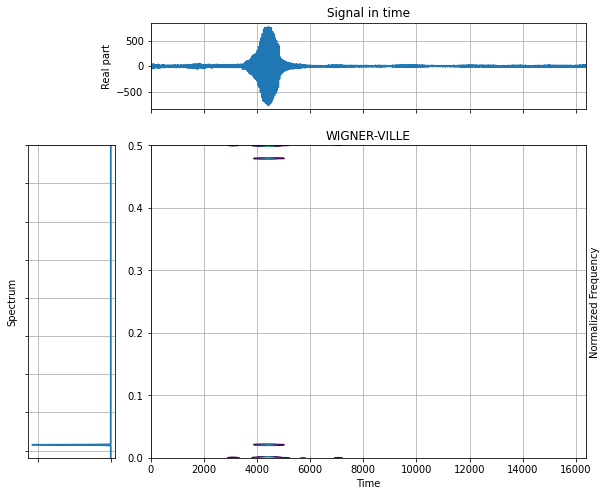

In [7]:
tfr = WignerVilleDistribution(array_obj_one[4])
tfr.run()
tfr.plot(kind='contour', show_tf=True)

In [ ]:
## Processing for object2
max_values_obj2 = []
sum_obj2 = []
max_value = 0;

for i in range(array_obj_two.shape[0]):
    tfr = WignerVilleDistribution(array_obj_two[i])
    tfr_wvd, t_wvd, f_wvd = tfr.run()
    tfr_array_np = np.array(tfr_wvd)
    max_value = np.amax(abs(tfr_array_np))
    sum_obj2.append(np.sum(tfr_array_np))
    max_values_obj2.append(max_value)

In [ ]:
## Processing for object1
max_values_obj1 = []
max_value = 0;
sum_obj1 = []

for i in range(array_obj_one.shape[0]):
    tfr = WignerVilleDistribution(array_obj_one[i])
    tfr_wvd, t_wvd, f_wvd = tfr.run()
    tfr_array_np = np.array(tfr_wvd)
    max_value = np.amax(abs(tfr_array_np))
    sum_obj1.append(np.sum(tfr_array_np))
    max_values_obj1.append(max_value)

In [ ]:
## Merging and creating data frame
max_freq_dataframe_obj_one = pd.DataFrame(max_values_obj1, columns=["MaxFrequency"])
max_freq_dataframe_obj_two = pd.DataFrame(max_values_obj2, columns=["MaxFrequency"])
sum_obj1 = pd.DataFrame(sum_obj1, columns=["MaxSpectrumSum"])
sum_obj2 = pd.DataFrame(sum_obj2, columns=["MaxSpectrumSum"])
print(max_freq_dataframe_obj_one.shape)
print(max_freq_dataframe_obj_two.shape)

In [ ]:
max_freq_dataframe_obj_one

In [ ]:
#sum_obj1["Target"] = 0
# sum_obj2["Target"] = 1
max_freq_dataframe_obj_one["Target"] = 0
max_freq_dataframe_obj_two["Target"] = 1

frames_freq = [max_freq_dataframe_obj_one, max_freq_dataframe_obj_two]
max_sum_frames = [sum_obj1, sum_obj2]
final_data_frame= pd.concat(frames)
final_freq_frame = pd.concat(frames_freq)
final_spe_roll = pd.concat(spectogram_rolloff)
final_max_sum = pd.concat(max_sum_frames)

# frames_final = [final_freq_frame, final_data_frame.reindex(final_freq_frame.index)]

# final_data_frame = pd.concat(frames_final, axis=1)
# frames_final[final_freq_frame]
# print(final_data_frame.shape)
# print(final_freq_frame.shape)
# frames_final = pd.merge(final_data_frame, final_spe_roll)
final_max_sum

In [ ]:
final_data_frame = pd.concat([final_freq_frame, final_max_sum], axis =1)
final_data_frame.isnull().values.any()
final_data_frame

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

# Now splitting the data to test and training sets, its important never let our model to learn from test.
X = final_data_frame.drop("Target", axis =1)
y = final_data_frame["Target"]
np.random.seed(42)

# split in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) # 20 % data to be used for testing
X

In [ ]:
y

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# put models in the dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decission Tree": tree.DecisionTreeClassifier()}

# Create a function to fit and score models
# fits and evaluates the machine learning models
# X_train: training data(no labels)
# X_test: testing data(no labels)
# y_train: training labels
# y_test: testing labels
def fit_and_score(models, X_train, X_test, y_train, y_test):
    
    # set a random seed
    np.random.seed(42)
    #Male a dictionary to keep model scores
    model_scores = {}
    #loop through models
    for name, model in models.items():
        # fit the mdoel to the data
        model.fit(X_train, y_train)
        # evaluate the mdoel and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [ ]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
model_scores

In [ ]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

In [ ]:
import pickle

# save the model to disk
filename = 'randomforest_model.sav'
pickle.dump(models["Random Forest"], open(filename, 'wb'))
 

In [ ]:
read_file = pd.read_csv('/Users/brian/Desktop/Discrimination-of-reflected-sound-signals/Files_for_task_2_and_4/Object_2/frontyellow-0.8/data/002.csv', header = None, usecols=list(range(16384)))
read_file.to_excel(r'/Users/brian/Desktop/Discrimination-of-reflected-sound-signals/test_obj1.xlsx', index=None)
test_data = pd.read_excel('test_obj1.xlsx')
test_data.shape

In [ ]:
read_file.shape

In [ ]:
array_test = np.array(read_file)
array_test[0]

In [ ]:
spectrum, freqs, t, im = plt.specgram(array_test[0], NFFT=256, Fs=2, noverlap=0)
test_max_freq = np.amax(abs(spectrum[0]))
test_max_sum = np.sum(spectrum)
# test_max_freq = np.array(test_max_freq)
# test_max_sum = np.array(test_max_sum)
# test_max_freq

In [ ]:
max_freq = pd.DataFrame([test_max_freq], columns=["MaxFrequency"])
sum_obj = pd.DataFrame([test_max_sum], columns=["MaxSpectrumSum"])
frames = [max_freq, sum_obj]
final_data_frame = pd.concat(frames, axis =1)
final_data_frame

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(final_data_frame)
print(result[0])

## Extracting features TP, TN, FP, FN, FDR, NPV, TPR, TNR, F1, ROC

1. TP, TN, FP, FN - Confusion matrix
2. F1, ROC - Done
3. FDR, NPV, TPR, TNR

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_actual = y_test
y_est = models["Random Forest"].predict(X_test)
cm = confusion_matrix(y_actual, y_est).ravel()
tn, fp, fn, tp  = cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm.reshape(2,2))
disp.plot()

In [ ]:
tpr = tp/(tp + fn)
tnr = tn/(tn + fp)
fdr = fp/(fp + tp)
npv = tn/(tn + fn)
print(tpr)
print(tnr)
print(fdr)
print(npv)
accuracy = (tp+tn)/(tp + tn + fp + fn)
precision = tp/(tp + fp)
values_all = {}
values_all["tpr"] = tp/(tp + fn)
values_all["tnr"] = tn/(tn + fp)
values_all["fdr"] = fp/(fp + tp)
values_all["npv"] = tn/(tn + fn)

values = pd.DataFrame(values_all, index=["Rates"])
values.T.plot.bar();
print("TPR:" + tpr +" \nTNR:"+ tnr+ "\nFDR, NPV, Accuracy and Precision")

In [ ]:
accuracy

In [ ]:
precision

In [ ]:
recall = tp/(tp + fn)
recall

In [ ]:
f1_score = 2 * (precision * recall)/(recall + precision)
f1_score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

plot_roc_curve(models["Random Forest"], X_test, y_test);

In [ ]:
# Confusion matrix
import seaborn as sns # build on top pf matplotlib

y_preds = models["Random Forest"].predict(X_test)

def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
plot_conf_mat(y_test, y_preds)

In [ ]:
# Check best hyperparameters
random_forest = models["Random Forest"]

In [ ]:
# Cross validated recall
cv_recall = cross_val_score(random_forest, X, y, cv=5, scoring="recall")

cv_recall_mean = np.mean(cv_recall)
cv_recall_mean

In [ ]:
# corss validated f1-score
cv_f1_score = cross_val_score(random_forest, X, y, cv=5, scoring="f1")

cv_rf_mean = np.mean(cv_f1_score)
cv_rf_mean

In [ ]:
from tftb.processing import WignerVilleDistribution

In [ ]:
tfr = WignerVilleDistribution(array_obj_two[3])

In [ ]:
tfr_wvd, t_wvd, f_wvd = tfr.run()

In [ ]:
fre_array_np = np.array(tfr_wvd)
a = np.count_nonzero(fre_array_np)
a

In [ ]:
len(f_wvd)

In [ ]:
tfr.plot(kind='contour', show_tf=True)

In [ ]:
tfr = WignerVilleDistribution(array_obj_two[3])
tfr.run()
tfr.plot(kind='contour', show_tf=True)

In [ ]:
tfr = WignerVilleDistribution(array_obj_two[6])
tfr_wvd, t_wvd, f_wvd = tfr.run()
fre_array_np = np.array(tfr_wvd)
test_max_freq = np.amax(fre_array_np)
test_max_sum = np.sum(fre_array_np)/
print(test_max_freq)
print(test_max_sum)

In [ ]:
len(tfr_wvd)

In [ ]:
tfr = WignerVilleDistribution(array_obj_one[6])
tfr_wvd, t_wvd, f_wvd = tfr.run()
fre_array_np = np.array(tfr_wvd)
test_max_freq = np.amax(fre_array_np)
test_max_sum = np.sum(fre_array_np)
print(test_max_freq)
print(test_max_sum)

In [ ]:
from scipy.signal import hilbert

In [ ]:
spectrum, freqs, t, im = plt.specgram(array_obj_two[6], NFFT=256, Fs=2, noverlap=0)
test_max_freq = np.amax(abs(spectrum[0]))
test_max_sum = np.sum(spectrum)
print(test_max_freq)
print(test_max_sum)

In [ ]:
len(spectrum)